In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.func as func
#import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

import sklearn.linear_model as linear_model

from mlgrad import averager_it, averager_fg, fg, erm_fg, irgd, erm_irgd, erisk, aerisk

In [2]:
# def gendataset(N=100, a=3., b=9., q=0.4, dy=2.):
#     M = int(q*N)
#     print(M)
#     X0 = np.linspace(-10., 10., N)
#     Y0 = 2.+3.*X0
#     Y0 += 2*dy*np.random.random(N)-dy
#     if q > 0:
#         X1 = -40*np.random.random(M) - 10
#         Y1 = -40*np.random.random(M) + 10
# #         Y1 += 2.+3.*X1 + 50
#         X2 = 40*np.random.random(M) + 10
#         Y2 = 40*np.random.random(M) - 10
# #         Y2 += 2.+3.*X2 - 50
#         X = np.hstack((X0, X1, X2))
#         Y = np.hstack((Y0, Y1, Y2))
#     else:
#         X = X0
#         Y = Y0
#     Xs = X.reshape(-1,1)
#     xrange = np.array(np.linspace(X.min(), X.max(), 10)).reshape(-1,1)
#     return X, Y, Xs, M, xrange

In [3]:
def gendataset(N=70, a=3., b=9., q=0.4, dy=2.):
    M = int(q*N)
    X0 = np.linspace(-10., 10., N+1)
    Y0 = 2.+3.*X0
    Y0 += 2*dy*np.random.random(N+1)-dy
    if q > 0:
        X1 = a*np.random.random(M) - a - 8
        Y1 = b*(2*np.random.random(M)-1)
        Y1 += 2.+3.*X1 + 50
        X2 = a*np.random.random(M) - a + 9
        Y2 = b*(2*np.random.random(M)-1)
        Y2 += 2.+3.*X2 - 50
        X = np.hstack((X0, X1, X2))
        Y = np.hstack((Y0, Y1, Y2))
    else:
        X = X0
        Y = Y0
    Xs = X.reshape(-1,1)
    xrange = np.linspace(-8., 8., 10).reshape(-1,1)
    return X, Y, Xs, M, xrange

In [4]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_hub = loss.ErrorLoss(func.Huber())
# loss_func_sqrt = loss.ErrorLoss(func.Sqrt())
loss_func_logsq = loss.ErrorLoss(func.LogSquare(1.))
# loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_tukey = loss.ErrorLoss(func.Tukey(33.))

In [5]:
N = 40
q = 0.4
dy = 4
X1, Y1, X1s, M, xrange0  = gendataset(N, q=q, dy=dy)
X0, Y0, X0s, M0, xrange0  = gendataset(N, q=0, dy=dy)
Q = 2*M / (N+2.*M) * 100
print(Q, X1.shape)

44.44444444444444 (73,)


982
373


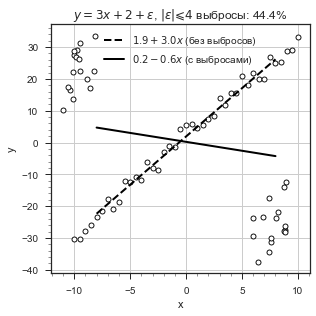

In [6]:
m0 = X0s.shape[1] + 1
param_init0 = np.array(np.random.random(m0))
lm_line0 = model.LinearModel(param_init0)
er0 = erisk(X0s, Y0, lm_line0, loss_func_sq)
alg0 = erm_fg(er0, h=0.1, tol=1.0e-6, n_iter=1000, n_restart=10)
print(alg0.K)

m1 = X1s.shape[1] + 1
param_init1 = np.array(np.random.random(m1))
lm_line1 = model.LinearModel(param_init1)
er1 = erisk(X1s, Y1, lm_line1, loss_func_sq)
alg1 = erm_fg(er1, h=0.1, tol=1.0e-6, n_iter=1000, n_restart=10)
print(alg1.K)

plt.figure(figsize=(4.5, 4.5))
plt.title(r'$y=3x+2+\varepsilon$, $|\varepsilon|\leqslant%s$ выбросы: %.1f%%' % (dy,Q,))
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, alg0.risk.model.evaluate_all(xrange0), color='k', linewidth=2., 
         label=r'$%.1f+%.1fx$ (без выбросов)' % tuple(lm_line0.param), linestyle='--')
plt.plot(xrange0, alg1.risk.model.evaluate_all(xrange0), color='k', linewidth=2., 
         label=r'$%.1f%.1fx$ (с выбросами)' % tuple(lm_line1.param), linestyle='-')
plt.grid(1)
plt.xlabel('x')
plt.ylabel('y')
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/rob_ml_linear_0.eps')
plt.show()

In [7]:
# E0 = np.abs(Y0-3*X0-2)
# E0.sort()
# E01 = np.abs(Y0-alg0.risk.model.evaluate_all(X0s))
# E01.sort()
# plt.figure(figsize=(4., 2.5))
# plt.plot(E0, marker='o', c='w', mec='k', mew=1.0, ms=4, label=r'$e_1^*,\dots,e_N^*$')
# plt.plot(E01, marker='+', c='w', mec='k', mew=1.0, ms=4, label=r'$\tilde e_1,\dots,\tilde e_N$')
# plt.legend()
# plt.tight_layout()
# plt.savefig('fig/rob_ml_linear_0_err.pdf')
# plt.show()

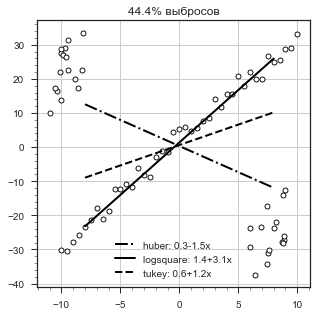

In [8]:
param_init2_hub = np.array([1.,1.])
# param_init2_sqrt = np.array([1.,1.])
param_init2_logsq = np.array([1.,1.])
param_init2_tukey = np.array([1.,1.])

lm_line2_hub = model.LinearModel(param_init2_hub)
# lm_line2_sqrt = model.LinearModel(param_init2_sqrt)
lm_line2_logsq = model.LinearModel(param_init2_logsq)
lm_line2_tukey = model.LinearModel(param_init2_tukey)

# er2_sqrt = erisk(X0s, Y0, lm_line2_sqrt, loss_func_sqrt)
er2_hub = erisk(X1s, Y1, lm_line2_hub, loss_func_hub)
er2_logsq = erisk(X1s, Y1, lm_line2_logsq, loss_func_logsq)
er2_tukey = erisk(X1s, Y1, lm_line2_tukey, loss_func_tukey)

alg2_hub = erm_fg(er2_hub, h=0.2, tol=1.0e-7, n_iter=1000)
# alg2_sqrt = erm_fg(er2_sqrt, h=0.1, tol=1.0e-7, n_iter=1000)
alg2_logsq = erm_fg(er2_logsq, h=0.2, tol=1.0e-7, n_iter=1000)
alg2_tukey = erm_fg(er2_tukey, h=0.2, tol=1.0e-7, n_iter=1000)

plt.figure(figsize=(4.5, 4.5))
plt.title("%.1f%% выбросов" % Q)
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
# plt.plot(xrange0, alg2_sqrt.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='$sqrt$', linestyle=':')
plt.plot(xrange0, alg2_hub.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='huber: %.1f%.1fx' % tuple(lm_line2_hub.param), linestyle='-.')
plt.plot(xrange0, alg2_logsq.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='logsquare: %.1f+%.1fx' % tuple(lm_line2_logsq.param), linestyle='-')
plt.plot(xrange0, alg2_tukey.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='tukey: %.1f+%.1fx' % tuple(lm_line2_tukey.param), linestyle='--')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/rb_ml_linear_0_classic.eps")
plt.show()

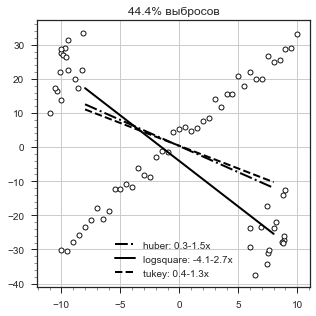

In [9]:
param_init22_hub = np.array([-1.,-1.])
param_init22_sqrt = np.array([-1.,-1.])
param_init22_logsq = np.array([-1.,-1.])
param_init22_tukey = np.array([-1.,-1.])

lm_line22_hub = model.LinearModel(param_init22_hub)
lm_line22_logsq = model.LinearModel(param_init22_logsq)
lm_line22_tukey = model.LinearModel(param_init22_tukey)

er22_hub = erisk(X1s, Y1, lm_line22_hub, loss_func_hub)
er22_logsq = erisk(X1s, Y1, lm_line22_logsq, loss_func_logsq)
er22_tukey = erisk(X1s, Y1, lm_line22_tukey, loss_func_tukey)

alg22_hub = erm_fg(er22_hub, h=0.2, tol=1.0e-7, n_iter=1000)
alg22_logsq = erm_fg(er22_logsq, h=0.2, tol=1.0e-7, n_iter=1000)
alg22_tukey = erm_fg(er22_tukey, h=0.2, tol=1.0e-7, n_iter=1000)

plt.figure(figsize=(4.5, 4.5))
plt.title("%.1f%% выбросов" % Q)
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, alg22_hub.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='huber: %.1f%.1fx' % tuple(lm_line22_hub.param), linestyle='-.')
plt.plot(xrange0, alg22_logsq.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='logsquare: %.1f%.1fx' % tuple(lm_line22_logsq.param), linestyle='-')
plt.plot(xrange0, alg22_tukey.risk.model.evaluate_all(xrange0), color='k', linewidth=2., label='tukey: %.1f%.1fx' % tuple(lm_line22_tukey.param), linestyle='--')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/rb_ml_linear_0_classic2.eps")
plt.show()

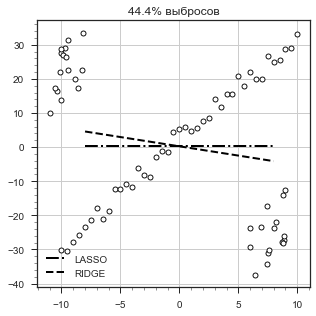

In [10]:
alg_ridge = linear_model.Ridge(alpha=100.)
alg_ridge.fit(X1s, Y1)
alg_lasso = linear_model.Lasso(alpha=100.)
alg_lasso.fit(X1s, Y1)

plt.figure(figsize=(4.5, 4.5))
plt.title("%.1f%% выбросов" % Q)
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, alg_lasso.predict(xrange0), color='k', linewidth=2., label=r'LASSO', linestyle='-.')
plt.plot(xrange0, alg_ridge.predict(xrange0), color='k', linewidth=2., label=r'RIDGE', linestyle='--')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/resistant_linear_lasso_80.png")
plt.show()

0.5555555555555556
K=22 param=[1.1109648  2.85305439]


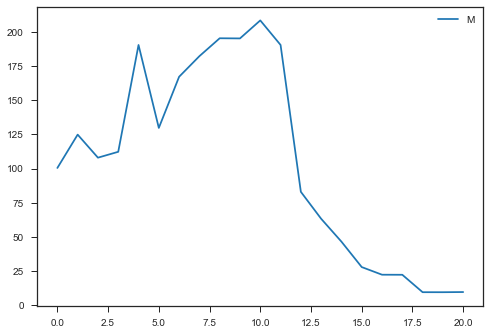

In [14]:
param_init3_m = np.array([1.,-1])

lm_line3_m = model.LinearModel(param_init3_m)

alpha = N / (N+2*M)
print(alpha)
er3_m = erisk(X1s, Y1, lm_line3_m, loss_func_sq)
fg3_m = fg(er3_m, h=0.001, tol=1.0e-8, n_iter=5000, stop_condition='diffL2')

avg3_m = averager_it(func.QuantileFunc(0.52, func.Sqrt(0.001)))
# avg3_m = averager_it(func.Power(1.05, 0.01))

wg3_m = weights.MWeights(avg3_m, er3_m, use_best_u=1)

alg3 = erm_irgd(fg3_m, wg3_m, n_iter=21, tol=1.0e-7, verbose=1)

plt.plot(alg3.lvals, label='M')
plt.legend()
plt.show()

K=201 param=[2.40267006 2.8979019 ]


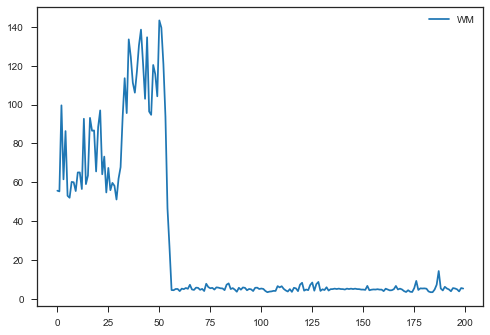

In [15]:
param_init3_wm = np.array([1.,-1])

lm_line3_wm = model.LinearModel(param_init3_wm)

er3_wm = erisk(X1s, Y1, lm_line3_wm, loss_func_sq)
fg3_wm = fg(er3_wm, h=0.01, tol=1.0e-8, n_iter=5000, stop_condition='diffL2')
alpha = 0.52

avg3_wm = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
avg3_wm = avragg.WMAverage(avg3_wm)
wg3_wm = weights.MWeights(avg3_wm, er3_wm)

alg3_wm = erm_irgd(fg3_wm, wg3_wm, n_iter=200, tol=1.0e-7, verbose=1)
plt.plot(alg3_wm.lvals, label='WM')
plt.legend()
plt.show()

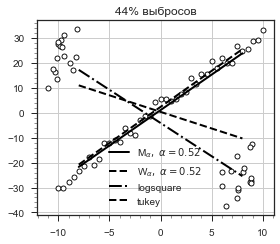

In [19]:
plt.figure(figsize=(4., 3.5))
plt.title("%.0f%% выбросов" % Q)
plt.scatter(X1, Y1, s=25, marker='o', c='w', edgecolors='k', linewidths=0.9) #, label='data')
plt.plot(xrange0, lm_line3_m.evaluate_all(xrange0), color='k', linewidth=2., 
         label=r'M$_\alpha,\ \alpha=%.2f$' % alpha, linestyle='-')
plt.plot(xrange0, lm_line3_wm.evaluate_all(xrange0), color='k', linewidth=2., 
         label=r'W$_\alpha,\ \alpha=%.2f$' % alpha, linestyle='--')
plt.plot(xrange0, lm_line22_logsq.evaluate_all(xrange0), color='k', linewidth=2., label='logsquare', linestyle='-.')
plt.plot(xrange0, lm_line22_tukey.evaluate_all(xrange0), color='k', linewidth=2., label='tukey', linestyle='--')
plt.grid(1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("fig/rb_ml_linear_robust_%.2f.eps" % alpha)
plt.show()